In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import gurobipy as gp
from gurobipy import GRB
from numpy.typing import NDArray
from scipy.optimize import minimize
from typing import Tuple
import time as time

In [2]:
# 価格を生成する関数
def create_price(r_mean: float, r_std: float, M: int) -> NDArray[np.float_]:
    # r_mean = (r_min + r_max) / 2
    # r_std = (r_max - r_mean) / 2
    # r_minとr_maxの間のランダムな0.1刻みの少数をM個生成
    price = np.random.normal(r_mean, r_std, size=M)
    # price = np.round(price, 1)

    return price


# alphaを作成する関数
def alpha_star(M: int) -> NDArray[np.float_]:
    alpha_star = np.random.uniform(M, 3 * M, size=M)
    return alpha_star


# betaを作成する関数
def beta_star(M: int, M_prime: int) -> NDArray[np.float_]:
    beta_star = np.zeros((M, M_prime))

    for m in range(M):
        for m_prime in range(M_prime):
            if m == m_prime:
                beta_star[m, m_prime] = np.random.uniform(-3 * M, -2 * M)
            else:
                beta_star[m, m_prime] = np.random.uniform(0, 2)

    return beta_star


def quantity_function(
    price: NDArray[np.float_],
    alpha: NDArray[np.float_],
    beta: NDArray[np.float_],
    delta: float = 0.1,  # ノイズレベルを指定（例として0.1を使用）
) -> list[float]:
    M = len(price)
    quantity_list = []
    q_m_no_noise = []

    # ステップ1: ノイズなしのq_mを計算
    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]
        quantity = alpha[m] + sum_beta
        q_m_no_noise.append(quantity)

    # E[q_m^2]を計算
    E_q_m_squared = np.mean(np.array(q_m_no_noise) ** 2)

    # ステップ2: ノイズの標準偏差sigmaを計算
    sigma = delta * np.sqrt(E_q_m_squared)

    # ステップ3: ノイズを加えて最終的なq_mを計算
    for m in range(M):
        epsilon = np.random.normal(0, sigma)
        quantity = q_m_no_noise[m] + epsilon
        quantity_list.append(quantity)

    return quantity_list


def sales_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    sales_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        sales_list.append(quantity * price[m])

    return sales_list


def create_date(M, N, r_mean, r_std, delta=0.1):
    alpha = alpha_star(M)
    beta = beta_star(M, M)

    price_list = []
    quantity_list = []

    for _ in range(N):
        price = create_price(r_mean, r_std, M)
        quantity = quantity_function(price, alpha, beta, delta)
        price_list.append(price)
        quantity_list.append(quantity)

    X = np.array(price_list)
    Y = np.array(quantity_list)

    return alpha, beta, X, Y


def create_bounds(M, r_min, r_max):
    lb = np.full(M, r_min)
    ub = np.full(M, r_max)

    bounds = []
    for i in range(M):
        bounds.append(lb[i])

    for i in range(M):
        bounds.append(ub[i])

    default_bounds = [(r_min, r_max) for _ in range(M)]

    return lb, ub, bounds, default_bounds

In [3]:
# 目的関数を定義（最大化問題を最小化問題に変換）
def sales_objective_function(prices, alpha, beta, M):
    return -sum(
        prices[m] * (alpha[m] + sum(beta[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )


def sales_optimize(
    M: int,
    alpha: np.ndarray,
    beta: np.ndarray,
    bounds: list[tuple[float, float]],
) -> Tuple[float, np.ndarray]:
    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)

    # 最適化を実行
    result = minimize(
        sales_objective_function,
        initial_prices,
        args=(alpha, beta, M),
        bounds=bounds,
        method="L-BFGS-B",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices

In [4]:
# 目的関数を定義
def predict_objective_function(
    prices: NDArray[np.float_], intercepts: [float], coefs: [NDArray[np.float_]], M: int
) -> float:
    # 各変数の内容をデバッグ出力
    # print("prices:", prices)
    # print("intercepts:", intercepts)
    # print("coefs:", coefs)
    # print("M:", M)

    return -sum(
        prices[m]
        * (intercepts[m] + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )


# 予測と最適化を行う関数
def predict_optimize(
    M: int, X: NDArray[np.float_], Y: NDArray[np.float_], bounds: list[float]
) -> tuple[float, NDArray[np.float_]]:
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)
    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 最適化を実行
    result = minimize(
        predict_objective_function,
        initial_prices,
        args=(intercepts, coefs, M),
        bounds=bounds,
        method="L-BFGS-B",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices

In [5]:
# CVを行う関数
def cross_validation_lb(
    lb: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds = [(lb[m], 1.0) for m in range(M)]

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)


def esitimate_lb_nelder(lb, M, X, y, K, adaptive=True):
    # adaptive=Trueの場合、optionsにadaptive=Trueを指定
    bounds_nelder = minimize(
        cross_validation_lb,
        lb,
        args=(X, y, M, K),
        method="Nelder-Mead",
        bounds=[(0.6, 1.0) for _ in range(M)],
        options={"adaptive": adaptive},
    )

    bounds_list = []
    for i in range(M):
        bounds_list.append((bounds_nelder.x[i], 1.0))
    return -bounds_nelder.fun, bounds_list

In [6]:
# CVを行う関数
def cross_validation_bounds_zero(
    bounds: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds_list = []

    for i in range(M):
        if bounds[i] > bounds[i + M]:
            return 0

        else:
            bounds_list.append((bounds[i], bounds[i + M]))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds_list,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)


def estimate_bounds_zero_nelder(bounds, M, X, y, K, r_min, r_max, adaptive=True):
    bounds_nelder = minimize(
        cross_validation_bounds_zero,
        bounds,
        args=(X, y, M, K),
        method="Nelder-Mead",
        bounds=[(r_min, r_max) for _ in range(2 * M)],
        options={"adaptive": adaptive},
    )

    opt_bounds = []
    for i in range(M):
        opt_bounds.append((bounds_nelder.x[i], bounds_nelder.x[i + M]))

    return -bounds_nelder.fun, opt_bounds

In [7]:
# CVを行う関数
def cross_validation_ub(
    ub: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds = [(0.6, ub[m]) for m in range(M)]

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)


def esitimate_ub_nelder(ub, M, X, y, K, adaptive=True):
    # adaptive=Trueの場合、optionsにadaptive=Trueを指定
    bounds_nelder = minimize(
        cross_validation_ub,
        ub,
        args=(X, y, M, K),
        method="Nelder-Mead",
        bounds=[(0.6, 1.0) for _ in range(M)],
        options={"adaptive": adaptive},
    )

    bounds_list = []
    for i in range(M):
        bounds_list.append((0.6, bounds_nelder.x[i]))
    return -bounds_nelder.fun, bounds_list

In [8]:
# CVを行う関数
def cross_validation_bounds_penalty(
    bounds: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds_list = []

    for i in range(M):
        if bounds[i] > bounds[i + M]:
            penalty = 0
            for i in range(M):
                penalty += bounds[i] ** 2 + bounds[i + M] ** 2
            return penalty

        else:
            bounds_list.append((bounds[i], bounds[i + M]))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds_list,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)


def estimate_bounds_penalty_nelder(bounds, M, X, y, K, r_min, r_max, adaptive=True):
    bounds_nelder = minimize(
        cross_validation_bounds_zero,
        bounds,
        args=(X, y, M, K),
        method="Nelder-Mead",
        bounds=[(r_min, r_max) for _ in range(2 * M)],
        options={"adaptive": adaptive},
    )

    opt_bounds = []
    for i in range(M):
        opt_bounds.append((bounds_nelder.x[i], bounds_nelder.x[i + M]))

    return -bounds_nelder.fun, opt_bounds

In [9]:
# CVを行う関数
def cross_validation_bounds_penalty_each(
    bounds: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    bounds_range: float,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds_list = []

    for i in range(M):
        if bounds[i] > bounds[i + M]:
            penalty = 0
            for i in range(M):
                penalty += bounds[i] ** 2 + bounds[i + M] ** 2
            return penalty

        else:
            bounds_list.append((bounds[i], bounds[i + M]))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds_list,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    penalty = 0
    for i in range(M):
        if bounds_range < bounds[i + M] - bounds[i]:
            penalty += bounds[i + M] - bounds[i]

    return -np.mean(optimal_sales_list) + penalty


def estimate_bounds_penalty_nelder_each(
    bounds, M, X, y, K, r_min, r_max, bounds_range, adaptive=True
):
    bounds_nelder = minimize(
        cross_validation_bounds_penalty_each,
        bounds,
        args=(X, y, M, K, bounds_range),
        method="Nelder-Mead",
        bounds=[(r_min, r_max) for _ in range(2 * M)],
        options={"adaptive": adaptive},
    )

    opt_bounds = []
    for i in range(M):
        opt_bounds.append((bounds_nelder.x[i], bounds_nelder.x[i + M]))

    return -bounds_nelder.fun, opt_bounds

In [10]:
# CVを行う関数
def cross_validation(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    bounds: list[float],
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)


In [11]:
# CVを行う関数
def cross_validation_bounds_penalty_all(
    bounds: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    bounds_range: float,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds_list = []

    for i in range(M):
        if bounds[i] > bounds[i + M]:
            penalty = 0
            for i in range(M):
                penalty += bounds[i] ** 2 + bounds[i + M] ** 2
            return penalty

        else:
            bounds_list.append((bounds[i], bounds[i + M]))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds_list,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    penalty = 0
    for i in range(M):
        penalty += bounds[i + M] - bounds[i]

    # print(penalty)

    if penalty > M * bounds_range:
        return -np.mean(optimal_sales_list) + penalty
    else:
        return -np.mean(optimal_sales_list)


def estimate_bounds_penalty_nelder_all(
    bounds, M, X, y, K, r_min, r_max, bounds_range, adaptive=True
):
    bounds_nelder = minimize(
        cross_validation_bounds_penalty_all,
        bounds,
        args=(X, y, M, K, bounds_range),
        method="Nelder-Mead",
        bounds=[(r_min, r_max) for _ in range(2 * M)],
        options={"adaptive": adaptive},
    )

    opt_bounds = []
    for i in range(M):
        opt_bounds.append((bounds_nelder.x[i], bounds_nelder.x[i + M]))

    return -bounds_nelder.fun, opt_bounds

In [12]:
M = 5
N = 500
K = 5
r_min = 0.6
r_max = 1.0
r_mean = 0.8
r_std = 0.1
bounds_range = 0.3

lb, ub, bounds, default_bounds = create_bounds(M, r_min, r_max)

In [13]:
# M = 5で　10回実行

M = 5
N = 500
K = 5
r_min = 0.6
r_max = 1.0
r_mean = 0.8
r_std = 0.1
bounds_range = 0.35

lb, ub, bounds, default_bounds = create_bounds(M, r_min, r_max)


so_salse_list_5 = []
po_sales_list_5 = []
true_po_salse_list_5 = []
cv_list_5 = []
elb_po_salse_list_5 = []
true_elb_po_salse_list_5 = []
eub_po_salse_list_5 = []
true_eub_po_salse_list_5 = []
ebz_po_salse_list_5 = []
true_ebz_po_salse_list_5 = []
ebp_po_salse_list_5 = []
true_ebp_po_salse_list_5 = []
ebpe_po_salse_list_5 = []
true_ebpe_po_salse_list_5 = []
ebpa_po_salse_list_5 = []
true_ebpa_po_salse_list_5 = []

for i in range(10):
    alpha, beta, X, Y = create_date(M, N, r_mean, r_std, delta=0.6)
    so_salse, so_prices = sales_optimize(M, alpha, beta, default_bounds)
    po_sales, po_prices = predict_optimize(M, X, Y, default_bounds)
    true_po_sales = sum(sales_function(po_prices, alpha, beta))
    cv_sales = cross_validation(X, Y, M, K, default_bounds)

    so_salse_list_5.append(so_salse / so_salse)
    po_sales_list_5.append(po_sales / so_salse)
    true_po_salse_list_5.append(true_po_sales / so_salse)
    cv_list_5.append(cv_sales / so_salse)

    # elb
    elb_sales, elb_bounds = esitimate_lb_nelder(lb, M, X, Y, K)
    elb_po_salse, elb_po_prices = predict_optimize(M, X, Y, elb_bounds)
    true_elb_po_sales = sum(sales_function(elb_po_prices, alpha, beta))

    elb_po_salse_list_5.append(elb_po_salse / so_salse)
    true_elb_po_salse_list_5.append(true_elb_po_sales / so_salse)

    # eub
    eub_sales, eub_bounds = esitimate_ub_nelder(ub, M, X, Y, K)
    eub_po_salse, eub_po_prices = predict_optimize(M, X, Y, eub_bounds)

    true_eub_po_sales = sum(sales_function(eub_po_prices, alpha, beta))

    eub_po_salse_list_5.append(eub_po_salse / so_salse)
    true_eub_po_salse_list_5.append(true_eub_po_sales / so_salse)

    # ebz
    ebz_sales, ebz_bounds = estimate_bounds_zero_nelder(bounds, M, X, Y, K, r_min, r_max)
    ebz_po_salse, ebz_po_prices = predict_optimize(M, X, Y, ebz_bounds)
    true_ebz_po_sales = sum(sales_function(ebz_po_prices, alpha, beta))

    ebz_po_salse_list_5.append(ebz_po_salse / so_salse)
    true_ebz_po_salse_list_5.append(true_ebz_po_sales / so_salse)

    # ebp
    ebp_sales, ebp_bounds = estimate_bounds_penalty_nelder(bounds, M, X, Y, K, r_min, r_max)
    ebp_po_salse, ebp_po_prices = predict_optimize(M, X, Y, ebp_bounds)
    true_ebp_po_sales = sum(sales_function(ebp_po_prices, alpha, beta))

    ebp_po_salse_list_5.append(ebp_po_salse / so_salse)
    true_ebp_po_salse_list_5.append(true_ebp_po_sales / so_salse)

    # ebpe
    ebpe_sales, ebpe_bounds = estimate_bounds_penalty_nelder_each(
        bounds, M, X, Y, K, r_min, r_max, bounds_range
    )
    ebpe_po_salse, ebpe_po_prices = predict_optimize(M, X, Y, ebpe_bounds)
    true_ebpe_po_salse = sum(sales_function(ebpe_po_prices, alpha, beta))

    ebpe_po_salse_list_5.append(ebpe_po_salse / so_salse)
    true_ebpe_po_salse_list_5.append(true_ebpe_po_salse / so_salse)

    # ebpa
    ebpa_sales, ebpa_bounds = estimate_bounds_penalty_nelder_all(
        bounds, M, X, Y, K, r_min, r_max, bounds_range
    )
    ebpa_po_salse, ebpa_po_prices = predict_optimize(M, X, Y, ebpa_bounds)
    true_ebpa_po_sales = sum(sales_function(ebpa_po_prices, alpha, beta))

    ebpa_po_salse_list_5.append(ebpa_po_salse / so_salse)
    true_ebpa_po_salse_list_5.append(true_ebpa_po_sales / so_salse)

In [14]:
# 平均を計算
so_salse_list_5_mean = np.mean(so_salse_list_5)
po_sales_list_5_mean = np.mean(po_sales_list_5)
true_po_salse_list_5_mean = np.mean(true_po_salse_list_5)
cv_list_5_mean = np.mean(cv_list_5)
elb_po_salse_list_5_mean = np.mean(elb_po_salse_list_5)
true_elb_po_salse_list_5_mean = np.mean(true_elb_po_salse_list_5)
eub_po_salse_list_5_mean = np.mean(eub_po_salse_list_5)
true_eub_po_salse_list_5_mean = np.mean(true_eub_po_salse_list_5)
ebz_po_salse_list_5_mean = np.mean(ebz_po_salse_list_5)
true_ebz_po_salse_list_5_mean = np.mean(true_ebz_po_salse_list_5)
ebp_po_salse_list_5_mean = np.mean(ebp_po_salse_list_5)
true_ebp_po_salse_list_5_mean = np.mean(true_ebp_po_salse_list_5)
ebpe_po_salse_list_5_mean = np.mean(ebpe_po_salse_list_5)
true_ebpe_po_salse_list_5_mean = np.mean(true_ebpe_po_salse_list_5)
ebpa_po_salse_list_5_mean = np.mean(ebpa_po_salse_list_5)
true_ebpa_po_salse_list_5_mean = np.mean(true_ebpa_po_salse_list_5)

In [15]:
label_list = [
    r"$f(z^*,\theta^*)$",
    r"$f(\hat{z},\hat\theta)$",
    r"$f(\hat{z},\theta^*)$",
    r"cv",
    r"$f(\bar{z},\bar\theta)$",
    r"$f(\bar{z},\theta^*)$",
]

In [16]:
color_list = ["red", "blue", "green", "purple", "orange", "pink"]

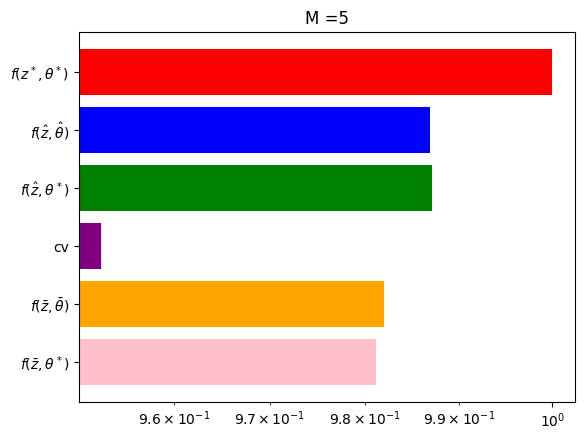

In [17]:
# elbの結果を表示
data_elb_5 = [
    so_salse_list_5_mean,
    po_sales_list_5_mean,
    true_po_salse_list_5_mean,
    cv_list_5_mean,
    elb_po_salse_list_5_mean,
    true_elb_po_salse_list_5_mean,
]


plt.barh(label_list, data_elb_5, color=color_list)
plt.xscale("log")
# 順番を逆転
plt.gca().invert_yaxis()
plt.title("M =5")
plt.show()

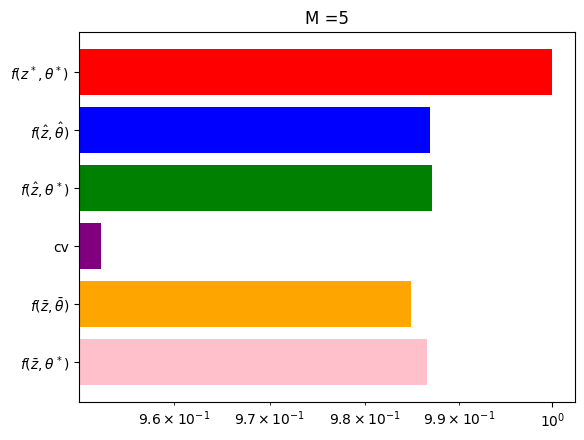

In [18]:
# eubの結果を表示
data_eub_5 = [
    so_salse_list_5_mean,
    po_sales_list_5_mean,
    true_po_salse_list_5_mean,
    cv_list_5_mean,
    eub_po_salse_list_5_mean,
    true_eub_po_salse_list_5_mean,
]


plt.barh(label_list, data_eub_5, color=color_list)
plt.xscale("log")
# 順番を逆転
plt.gca().invert_yaxis()
plt.title("M =5")
plt.show()

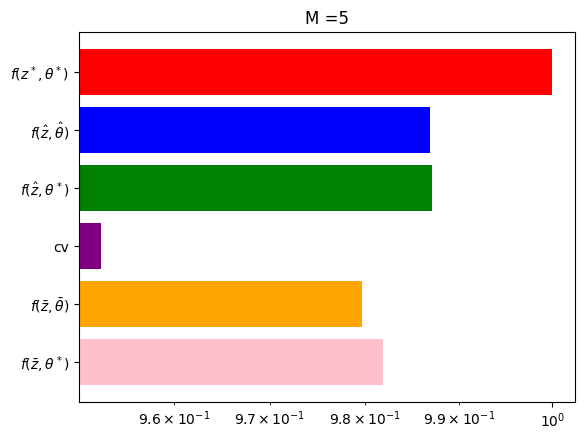

In [19]:
# ebzの結果を表示
data_ebz_5 = [
    so_salse_list_5_mean,
    po_sales_list_5_mean,
    true_po_salse_list_5_mean,
    cv_list_5_mean,
    ebz_po_salse_list_5_mean,
    true_ebz_po_salse_list_5_mean,
]


plt.barh(label_list, data_ebz_5, color=color_list)
plt.xscale("log")
# 順番を逆転
plt.gca().invert_yaxis()
plt.title("M =5")
plt.show()

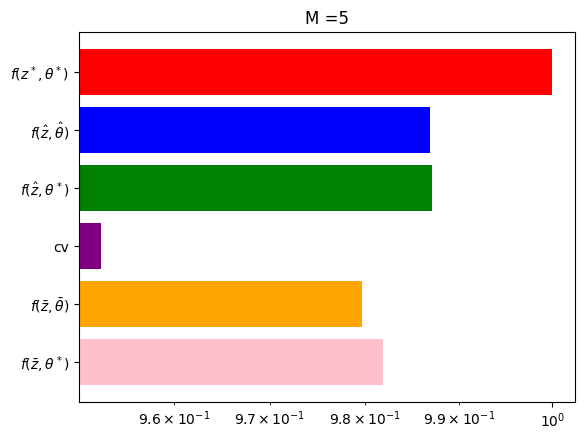

In [20]:
# ebpの結果を表示
data_ebp_5 = [
    so_salse_list_5_mean,
    po_sales_list_5_mean,
    true_po_salse_list_5_mean,
    cv_list_5_mean,
    ebp_po_salse_list_5_mean,
    true_ebp_po_salse_list_5_mean,
]


plt.barh(label_list, data_ebp_5, color=color_list)
plt.xscale("log")
# 順番を逆転
plt.gca().invert_yaxis()
plt.title("M =5")
plt.show()

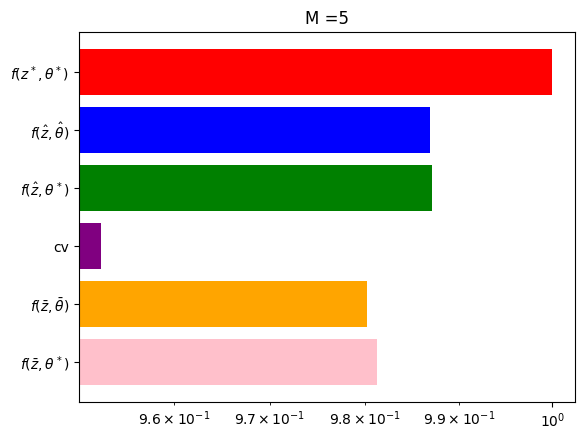

In [21]:
# ebpeの結果を表示
data_ebpe_5 = [
    so_salse_list_5_mean,
    po_sales_list_5_mean,
    true_po_salse_list_5_mean,
    cv_list_5_mean,
    ebpe_po_salse_list_5_mean,
    true_ebpe_po_salse_list_5_mean,
]


plt.barh(label_list, data_ebpe_5, color=color_list)
plt.xscale("log")
# 順番を逆転
plt.gca().invert_yaxis()
plt.title("M =5")
plt.show()

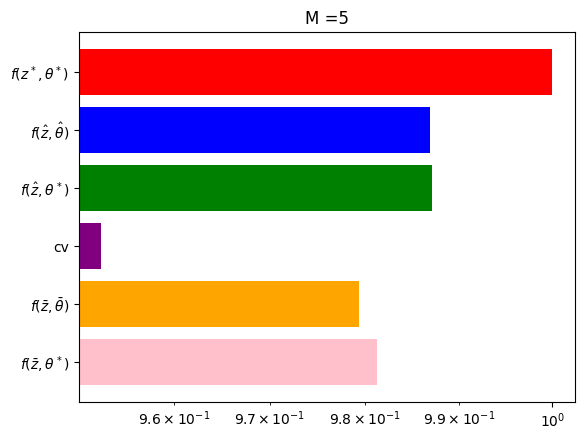

In [22]:
# ebpaの結果を表示
data_ebpa_5 = [
    so_salse_list_5_mean,
    po_sales_list_5_mean,
    true_po_salse_list_5_mean,
    cv_list_5_mean,
    ebpa_po_salse_list_5_mean,
    true_ebpa_po_salse_list_5_mean,
]


plt.barh(label_list, data_ebpa_5, color=color_list)
plt.xscale("log")
# 順番を逆転
plt.gca().invert_yaxis()
plt.title("M =5")
plt.show()

In [23]:
label_h = [r"$f(z^*,\theta^*)$", "lb", "ub", "zero", "penalty", "each_penalty", "all_penalty"]

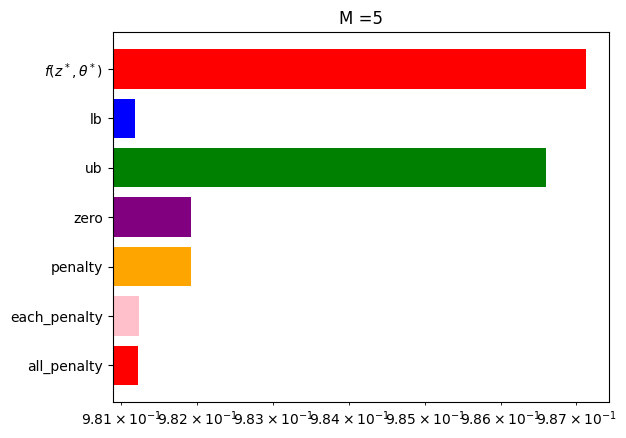

In [24]:
# true_po,true_elb,true_eub,true_ebz,true_ebp,true_ebpe,true_ebpaのmeanを表示
data_h_6 = [
    true_po_salse_list_5_mean,
    true_elb_po_salse_list_5_mean,
    true_eub_po_salse_list_5_mean,
    true_ebz_po_salse_list_5_mean,
    true_ebp_po_salse_list_5_mean,
    true_ebpe_po_salse_list_5_mean,
    true_ebpa_po_salse_list_5_mean,
]


plt.barh(label_h, data_h_6, color=color_list)
plt.xscale("log")
# 順番を逆転
plt.gca().invert_yaxis()
plt.title("M =5")
plt.show()

In [25]:
ebpa_bounds

[(0.6033465801404813, 0.9799675940261305),
 (0.7680264078259569, 0.9736667745512595),
 (0.6, 0.997912814386598),
 (0.6034564868018721, 0.9388110283406647),
 (0.6000000117834744, 0.9933711142059918)]

In [26]:
so_prices

array([0.76996965, 0.60784682, 0.6       , 0.79834068, 0.6       ])

In [27]:
for i in range(10):
    print(i)
    print(true_po_salse_list_5[i] < true_elb_po_salse_list_5[i])
    print(true_po_salse_list_5[i] < true_eub_po_salse_list_5[i])
    print(true_po_salse_list_5[i] < true_ebz_po_salse_list_5[i])
    print(true_po_salse_list_5[i] < true_ebp_po_salse_list_5[i])
    print(true_po_salse_list_5[i] < true_ebpe_po_salse_list_5[i])
    print(true_po_salse_list_5[i] < true_ebpa_po_salse_list_5[i])


0
False
False
True
True
True
False
1
False
False
False
False
False
False
2
False
False
False
False
False
False
3
False
False
False
False
False
False
4
False
True
True
True
True
True
5
True
False
True
True
True
True
6
False
True
True
True
False
True
7
False
False
False
False
False
False
8
False
False
False
False
False
False
9
False
False
False
False
False
False


In [28]:
for i in range(M):
    print(ebpe_bounds[i][1] - ebpe_bounds[i][0])


0.3296659674716489
0.22856506124575549
0.3486462255006081
0.27692738411386486
0.3260115964020609


In [29]:
# M =10で　10回実行

M = 10
N = 500
K = 5

lb, ub, bounds, default_bounds = create_bounds(M, r_min, r_max)


so_salse_list_10 = []
po_sales_list_10 = []
true_po_salse_list_10 = []
cv_list_10 = []
elb_po_salse_list_10 = []
true_elb_po_salse_list_10 = []
eub_po_salse_list_10 = []
true_eub_po_salse_list_10 = []
ebz_po_salse_list_10 = []
true_ebz_po_salse_list_10 = []
ebp_po_salse_list_10 = []
true_ebp_po_salse_list_10 = []
ebpe_po_salse_list_10 = []
true_ebpe_po_salse_list_10 = []
ebpa_po_salse_list_10 = []
true_ebpa_po_salse_list_10 = []

for i in range(10):
    alpha, beta, X, Y = create_date(M, N, r_mean, r_std, delta=0.6)
    so_salse, so_prices = sales_optimize(M, alpha, beta, default_bounds)
    po_sales, po_prices = predict_optimize(M, X, Y, default_bounds)
    true_po_sales = sum(sales_function(po_prices, alpha, beta))
    cv_sales = cross_validation(X, Y, M, K, default_bounds)

    so_salse_list_10.append(so_salse / so_salse)
    po_sales_list_10.append(po_sales / so_salse)
    true_po_salse_list_10.append(true_po_sales / so_salse)
    cv_list_10.append(cv_sales / so_salse)

    # elb
    elb_sales, elb_bounds = esitimate_lb_nelder(lb, M, X, Y, K)
    elb_po_salse, elb_po_prices = predict_optimize(M, X, Y, elb_bounds)
    true_elb_po_sales = sum(sales_function(elb_po_prices, alpha, beta))

    elb_po_salse_list_10.append(elb_po_salse / so_salse)
    true_elb_po_salse_list_10.append(true_elb_po_sales / so_salse)

    # eub
    eub_sales, eub_bounds = esitimate_ub_nelder(ub, M, X, Y, K)
    eub_po_salse, eub_po_prices = predict_optimize(M, X, Y, eub_bounds)
    true_eub_po_sales = sum(sales_function(eub_po_prices, alpha, beta))

    eub_po_salse_list_10.append(eub_po_salse / so_salse)
    true_eub_po_salse_list_10.append(true_eub_po_sales / so_salse)

    # ebz
    ebz_sales, ebz_bounds = estimate_bounds_zero_nelder(bounds, M, X, Y, K, r_min, r_max)
    ebz_po_salse, ebz_po_prices = predict_optimize(M, X, Y, ebz_bounds)
    true_ebz_po_sales = sum(sales_function(ebz_po_prices, alpha, beta))

    ebz_po_salse_list_10.append(ebz_po_salse / so_salse)
    true_ebz_po_salse_list_10.append(true_ebz_po_sales / so_salse)

    # ebp
    ebp_sales, ebp_bounds = estimate_bounds_penalty_nelder(bounds, M, X, Y, K, r_min, r_max)
    ebp_po_salse, ebp_po_prices = predict_optimize(M, X, Y, ebp_bounds)

    true_ebp_po_sales = sum(sales_function(ebp_po_prices, alpha, beta))

    ebp_po_salse_list_10.append(ebp_po_salse / so_salse)
    true_ebp_po_salse_list_10.append(true_ebp_po_sales / so_salse)

    # ebpe
    ebpe_sales, ebpe_bounds = estimate_bounds_penalty_nelder_each(
        bounds, M, X, Y, K, r_min, r_max, bounds_range
    )
    ebpe_po_salse, ebpe_po_prices = predict_optimize(M, X, Y, ebpe_bounds)
    true_ebpe_salse = sum(sales_function(ebpe_po_prices, alpha, beta))

    ebpe_po_salse_list_10.append(ebpe_po_salse / so_salse)
    true_ebpe_po_salse_list_10.append(true_ebpe_salse / so_salse)

    # ebpa
    ebpa_sales, ebpa_bounds = estimate_bounds_penalty_nelder_all(
        bounds, M, X, Y, K, r_min, r_max, bounds_range
    )
    ebpa_po_salse, ebpa_po_prices = predict_optimize(M, X, Y, ebpa_bounds)

    true_ebpa_po_sales = sum(sales_function(ebpa_po_prices, alpha, beta))

    ebpa_po_salse_list_10.append(ebpa_po_salse / so_salse)
    true_ebpa_po_salse_list_10.append(true_ebpa_po_sales / so_salse)

In [31]:
# 平均を計算
so_salse_list_10_mean = np.mean(so_salse_list_10)
po_sales_list_10_mean = np.mean(po_sales_list_10)
true_po_salse_list_10_mean = np.mean(true_po_salse_list_10)
cv_list_10_mean = np.mean(cv_list_10)
elb_po_salse_list_10_mean = np.mean(elb_po_salse_list_10)
true_elb_po_salse_list_10_mean = np.mean(true_elb_po_salse_list_10)
eub_po_salse_list_10_mean = np.mean(eub_po_salse_list_10)
true_eub_po_salse_list_10_mean = np.mean(true_eub_po_salse_list_10)
ebz_po_salse_list_10_mean = np.mean(ebz_po_salse_list_10)
true_ebz_po_salse_list_10_mean = np.mean(true_ebz_po_salse_list_10)
ebp_po_salse_list_10_mean = np.mean(ebp_po_salse_list_10)
true_ebp_po_salse_list_10_mean = np.mean(true_ebp_po_salse_list_10)
ebpe_po_salse_list_10_mean = np.mean(ebpe_po_salse_list_10)
true_ebpe_po_salse_list_10_mean = np.mean(true_ebpe_po_salse_list_10)
ebpa_po_salse_list_10_mean = np.mean(ebpa_po_salse_list_10)
true_ebpa_po_salse_list_10_mean = np.mean(true_ebpa_po_salse_list_10)

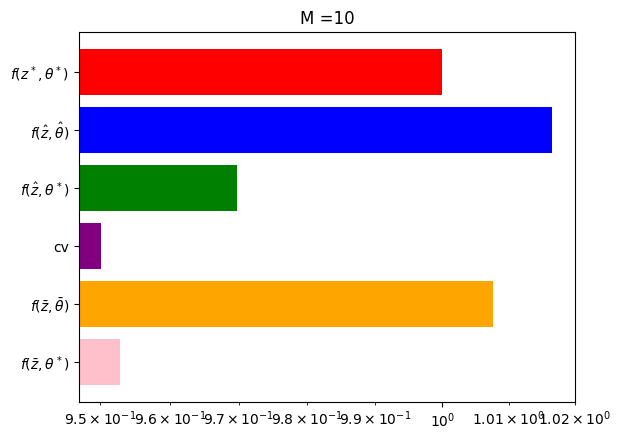

In [32]:
# elbの結果を表示
data_elb_10 = [
    so_salse_list_10_mean,
    po_sales_list_10_mean,
    true_po_salse_list_10_mean,
    cv_list_10_mean,
    elb_po_salse_list_10_mean,
    true_elb_po_salse_list_10_mean,
]


plt.barh(label_list, data_elb_10, color=color_list)
plt.xscale("log")
# 順番を逆転
plt.gca().invert_yaxis()
plt.title("M =10")
plt.show()


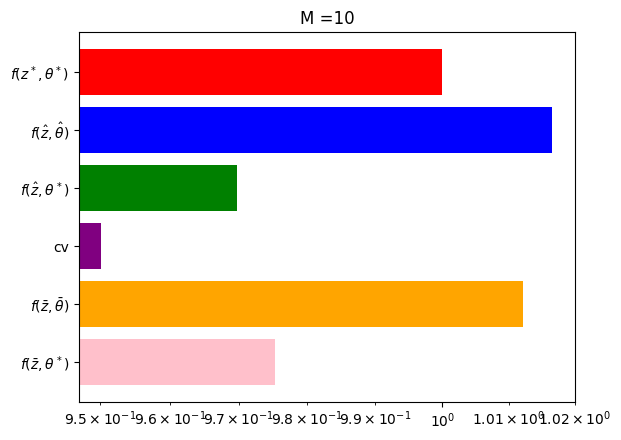

In [33]:
# eubの結果を表示
data_eub_10 = [
    so_salse_list_10_mean,
    po_sales_list_10_mean,
    true_po_salse_list_10_mean,
    cv_list_10_mean,
    eub_po_salse_list_10_mean,
    true_eub_po_salse_list_10_mean,
]


plt.barh(label_list, data_eub_10, color=color_list)
plt.xscale("log")
# 順番を逆転
plt.gca().invert_yaxis()
plt.title("M =10")
plt.show()


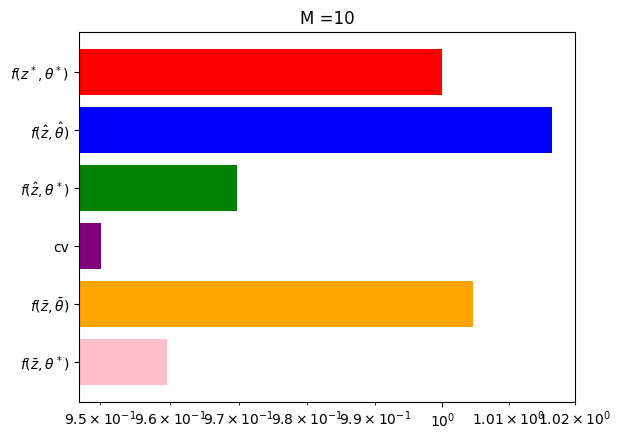

In [34]:
# ebzの結果を表示
data_ebz_10 = [
    so_salse_list_10_mean,
    po_sales_list_10_mean,
    true_po_salse_list_10_mean,
    cv_list_10_mean,
    ebz_po_salse_list_10_mean,
    true_ebz_po_salse_list_10_mean,
]


plt.barh(label_list, data_ebz_10, color=color_list)
plt.xscale("log")
# 順番を逆転
plt.gca().invert_yaxis()
plt.title("M =10")
plt.show()


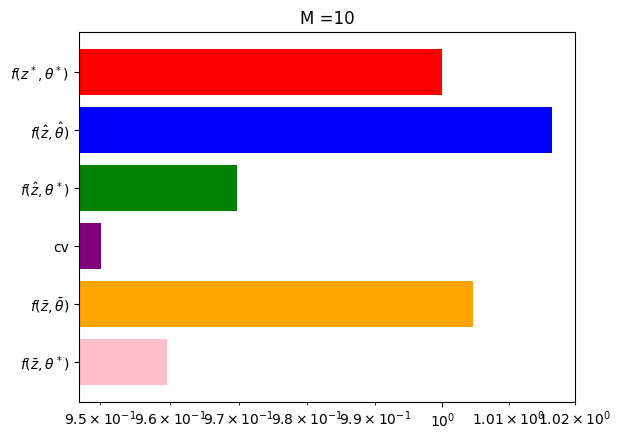

In [35]:
# ebpの結果を表示
data_ebp_10 = [
    so_salse_list_10_mean,
    po_sales_list_10_mean,
    true_po_salse_list_10_mean,
    cv_list_10_mean,
    ebp_po_salse_list_10_mean,
    true_ebp_po_salse_list_10_mean,
]


plt.barh(label_list, data_ebp_10, color=color_list)
plt.xscale("log")
# 順番を逆転
plt.gca().invert_yaxis()
plt.title("M =10")
plt.show()


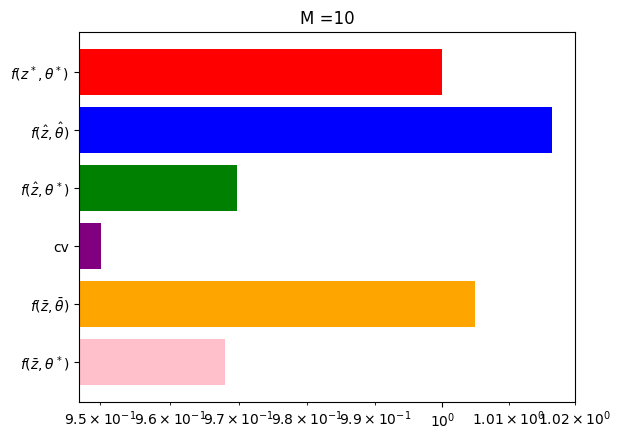

In [36]:
# ebpeの結果を表示
data_ebpe_10 = [
    so_salse_list_10_mean,
    po_sales_list_10_mean,
    true_po_salse_list_10_mean,
    cv_list_10_mean,
    ebpe_po_salse_list_10_mean,
    true_ebpe_po_salse_list_10_mean,
]


plt.barh(label_list, data_ebpe_10, color=color_list)
plt.xscale("log")
# 順番を逆転
plt.gca().invert_yaxis()
plt.title("M =10")
plt.show()


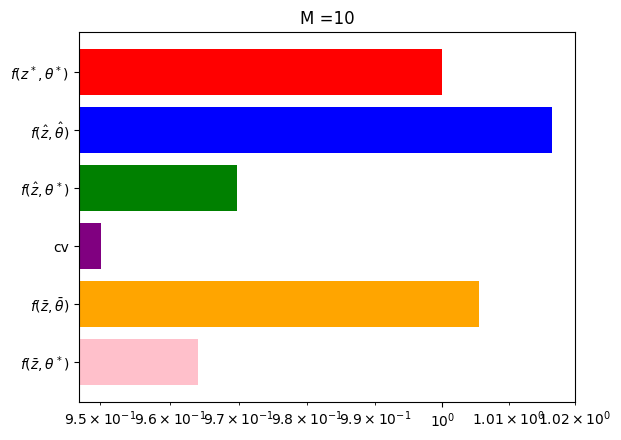

In [37]:
# ebpaの結果を表示

data_ebpa_10 = [
    so_salse_list_10_mean,
    po_sales_list_10_mean,
    true_po_salse_list_10_mean,
    cv_list_10_mean,
    ebpa_po_salse_list_10_mean,
    true_ebpa_po_salse_list_10_mean,
]


plt.barh(label_list, data_ebpa_10, color=color_list)
plt.xscale("log")
# 順番を逆転
plt.gca().invert_yaxis()
plt.title("M =10")
plt.show()


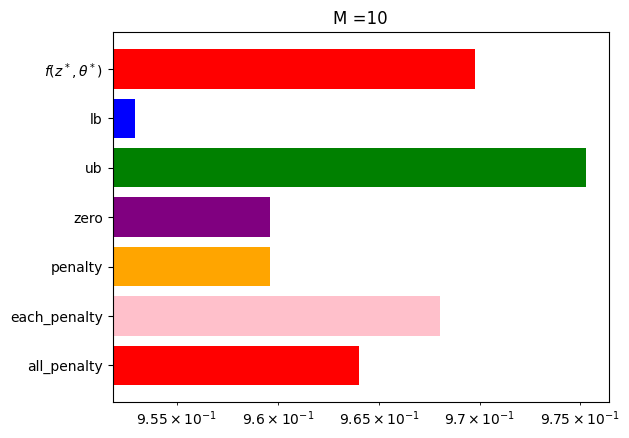

In [38]:
# true_po,true_elb,true_eub,true_ebz,true_ebp,true_ebpe,true_ebpaのmeanを表示
data_h_10 = [
    true_po_salse_list_10_mean,
    true_elb_po_salse_list_10_mean,
    true_eub_po_salse_list_10_mean,
    true_ebz_po_salse_list_10_mean,
    true_ebp_po_salse_list_10_mean,
    true_ebpe_po_salse_list_10_mean,
    true_ebpa_po_salse_list_10_mean,
]


plt.barh(label_h, data_h_10, color=color_list)
plt.xscale("log")
# 順番を逆転
plt.gca().invert_yaxis()
plt.title("M =10")
plt.show()
